In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import lightgbm as lgb
%matplotlib inline

In [2]:
data = pd.read_csv('datasets/final_elem+hard-feat_data.csv')
X = data.iloc[:,1:-1]
Y = data.iloc[:,-1]

In [3]:
def read_param():  ## function for reading saved hyperparameters
    f0 = open('datasets/best-paramters_lgb_optuna_TPE_plot.txt','r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = float(b[4][1])
    p5 = float(b[5][1]); p6 = int(b[6][1]); p7 = int(b[7][1]); p8 = float(b[8][1])
#     p9 = int(b[9][1])
    return p1, p2, p3, p4, p5, p6, p7, p8

p1, p2, p3, p4, p5, p6, p7, p8 = read_param()
params = {'objective': 'regression', 'boosting_type': 'gbdt', 'lambda_l1': p1,
          'lambda_l2': p2, 'num_leaves': p3, 'feature_fraction': p4, 
          'bagging_fraction': p5, 'bagging_freq': p6, 'min_child_samples': p7,
          'learning_rate': p8} 

In [4]:
## retrieving the best model
random = 595 ## change accordingly
test_size = 0.1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random)
#reg = lgb.Booster(model_file='datasets/best_model_lgbm.txt')
d_train = lgb.Dataset(X_train, label = Y_train)
reg = lgb.train(params, d_train)
Y_pred_test = reg.predict(X_test) 
Y_pred_train = reg.predict(X_train) 
rmse_test=np.sqrt(mean_squared_error(Y_test, Y_pred_test))
rmse_train=np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print(rmse_train, rmse_test) ## compare with the one obtained from finding the best ML model step

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1767
[LightGBM] [Info] Number of data points in the train set: 2789, number of used features: 11
[LightGBM] [Info] Start training from score -0.583265
0.09588191653257558 0.12614712537972475


## SHAP feature importance plot

In [5]:
explainerModel = shap.TreeExplainer(model = reg)
shap_values = explainerModel.shap_values(X)

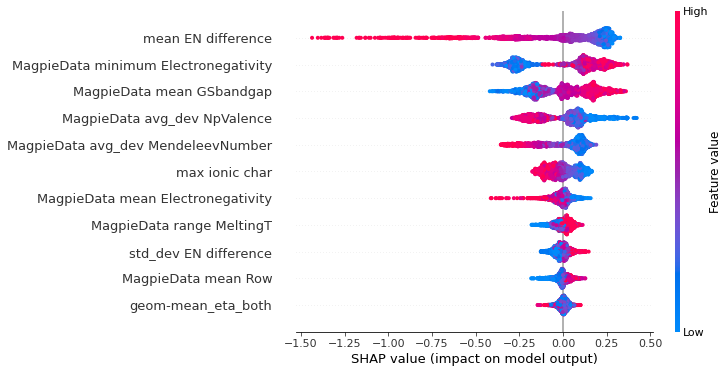

In [6]:
## Summary plot (Global interpretability)
shap.summary_plot(shap_values, X)
# plt.savefig('shap_feature-importance.ong', bbox_inches='tight', dpi=300)

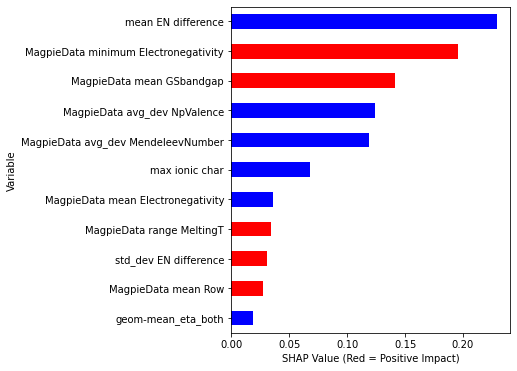

In [7]:
## 2nd type of bar plot of feature importance 
def abs_shap(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    plt.savefig('shap_feature-import_bar_convex.eps', bbox_inches='tight', dpi=300)
    
abs_shap(shap_values, X)

## SHAP dependence plots

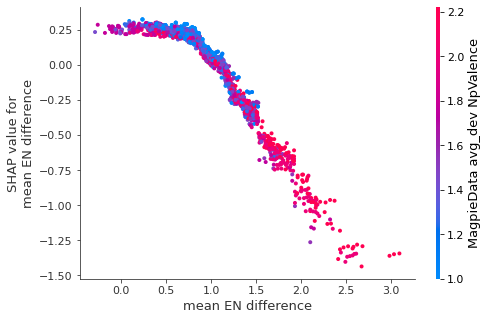

In [8]:
shap.dependence_plot('mean EN difference', shap_values, X)
# plt.savefig('shap_dp_mean_EN_diff.png', bbox_inches='tight', dpi=300)

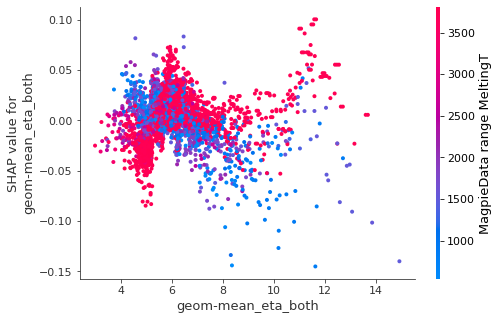

In [9]:
shap.dependence_plot('geom-mean_eta_both', shap_values, X)
# plt.savefig('shap_dp_mean_EN_diff.png', bbox_inches='tight', dpi=300)

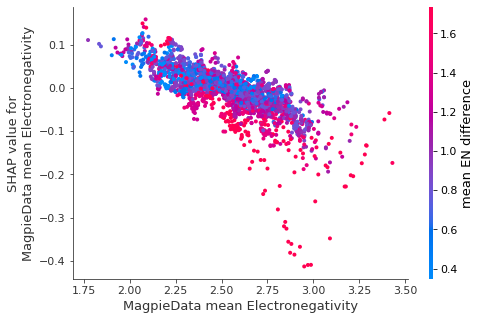

In [10]:
shap.dependence_plot('MagpieData mean Electronegativity', shap_values, X)
# plt.savefig('shap_dp_mean_EN_diff.png', bbox_inches='tight', dpi=300)

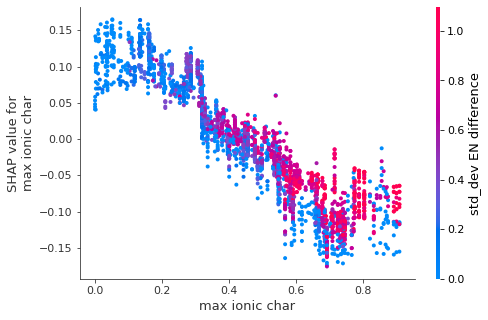

In [11]:
shap.dependence_plot('max ionic char', shap_values, X)
# plt.savefig('shap_dp_mean_EN_diff.png', bbox_inches='tight', dpi=300)

## SHAP force plots

In [12]:
## Local interpretability
shap.initjs()
def plot_indiv_shap(i):
    shap.force_plot(explainerModel.expected_value, shap_values[i], X.iloc[[i]], show=False, matplotlib=True)
#     f = 'shap_individual_' + str(i) + '.png'
#     plt.savefig(f, bbox_inches='tight', dpi=300)

In [13]:
comp = data['Compound']
print(comp.iloc[2101], Y.iloc[2101])
print(comp.iloc[2344], Y.iloc[2344])
print(comp.iloc[2641], Y.iloc[2641])
print(comp.iloc[2691], Y.iloc[2691])

NCS-NCO-Mg -0.6165192167
OCN-NCS-Mg -0.4297845067
SCN-NCO-Mg -0.4032273981
SCN-OCN-Mg -0.197627771


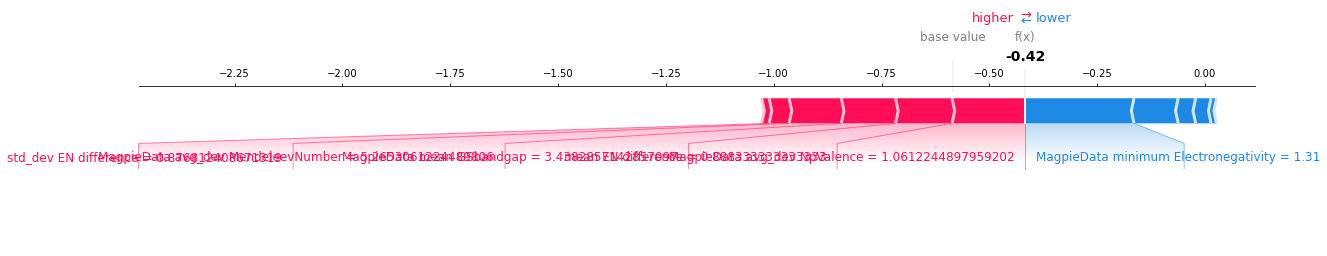

In [14]:
plot_indiv_shap(2101) # for NCS-NCO-Mg

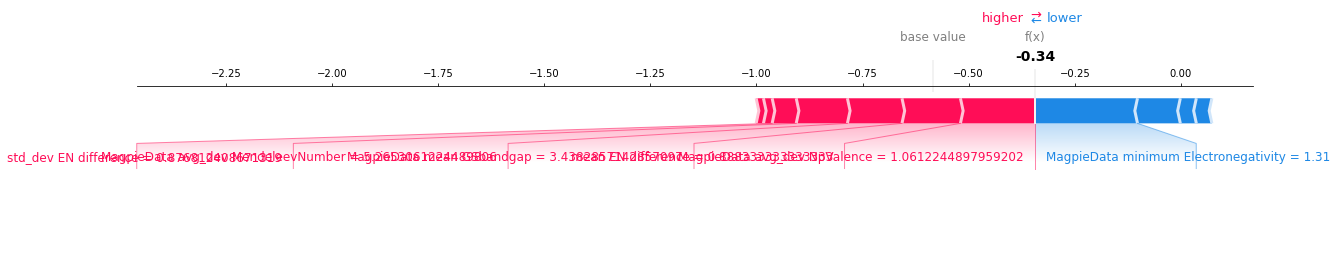

In [15]:
plot_indiv_shap(2344) # for OCN-NCS-Mg

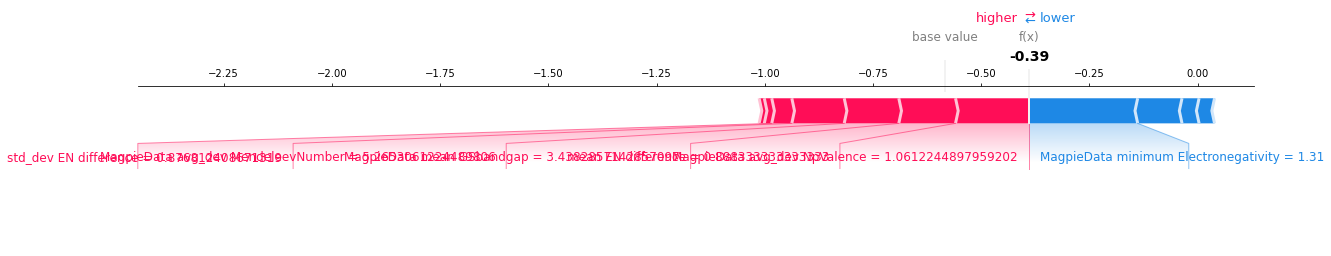

In [16]:
plot_indiv_shap(2641) # for SCN-NCO-Mg

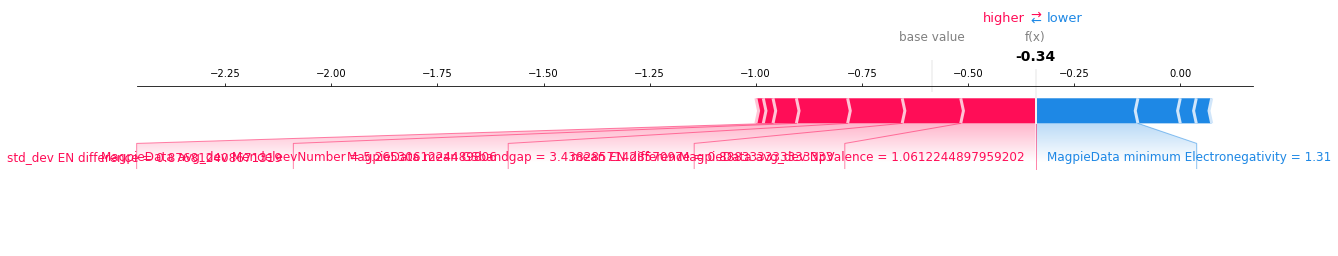

In [17]:
plot_indiv_shap(2691) # for SCN-OCN-Mg